![Add a relevant banner image here](Images\brendan-church-pKeF6Tt3c08-unsplash.jpg)

# Exploring the Impact of Weather, Infrastructure, and Day Part on Traffic Accident Severity

## Overview

This project seeks to identify relationships between the severity of traffic accidents and any of a wide range of associated conditions and factors.

I chose to focus on weather, road infrastructure, and time of day. I used a large database of traffic accidents that covered 2016 - 2023 for the 48 contiguous US states and the Distric of Columbia.

Key findings:

- Fair weather contributes most strongly to accident severity (not inclement weather as I expected)
- Accidents tend to be more severe around stop lights, stop signs, and pedestrian crossings; they tend to be less severe near roundabouts, bumps, and traffic calming devices
- Accident severity increases notably when ambient light is either zero or very low.

## Business Understanding

The Department of Transportation (DOT) has a clear and overriding interest in better understanding traffic accidents. Their ultimate goal isreducing both the number and severity of accidents, given the clear impact these factors have on public safety and quality of life as well as the direct economic costs of accidents.

The DOT and other partner/related agencies have both the benefit and challenge of copious data on accidents. Digital recordkeeping has brought a significant amount of data to these stakeholders; this abundance is also associated with a larger challenge in digesting and drawing conclusions.

The US Accidents dataset (https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents) that I'm working with in this project is a good example of this opportunity and challenge. The dataset includes 7.72 million records, each with up to 46 individual data elements. The data is a combination of numerical, text, and boolean; while it is by and large complete and consistent there are also notable gaps.

The decisionmakers and stakeholders at the DOT and related organizations would benefit from a deep dive into this dataset and help extracting insights from it. The goal of this work is to use advanced modeling and analytical techniques to distill clear, easy to understand insights.

## Data Understanding



In [1]:
# Load relevant imports here
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import gc
import csv
from datetime import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint, reciprocal


In [2]:
df_all_data = pd.read_csv('Data/US_Accidents_March23.csv')
print(df_all_data.head())

    ID   Source  Severity           Start_Time             End_Time  \
0  A-1  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00   
1  A-2  Source2         2  2016-02-08 06:07:59  2016-02-08 06:37:59   
2  A-3  Source2         2  2016-02-08 06:49:27  2016-02-08 07:19:27   
3  A-4  Source2         3  2016-02-08 07:23:34  2016-02-08 07:53:34   
4  A-5  Source2         2  2016-02-08 07:39:07  2016-02-08 08:09:07   

   Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Roundabout  \
0  39.865147 -84.058723      NaN      NaN          0.01  ...      False   
1  39.928059 -82.831184      NaN      NaN          0.01  ...      False   
2  39.063148 -84.032608      NaN      NaN          0.01  ...      False   
3  39.747753 -84.205582      NaN      NaN          0.01  ...      False   
4  39.627781 -84.188354      NaN      NaN          0.01  ...      False   

  Station   Stop Traffic_Calming Traffic_Signal Turning_Loop Sunrise_Sunset  \
0   False  False           False          F

In [4]:
print(df_all_data.info())
print(df_all_data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

In [3]:
df_severity_by_state = pd.crosstab(df_all_data['Severity'], df_all_data['State'])

totals = df_severity_by_state.sum()

for i in range(4):
    pct_row = (df_severity_by_state.iloc[i] / totals) * 100
    df_severity_by_state.loc[f'Row{i+1}_pct'] = pct_row

df_severity_by_state

State,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
Severity,,,,,,,,,,,,,,,,,,,,,
1,681.000000,37.000000,7389.000000,1.028400e+04,970.000000,72.000000,143.000000,234.000000,7083.000000,1007.000000,...,0.000000,2335.000000,4233.000000,632.000000,3115.000000,3.000000,865.000000,90.000000,2.000000,0.000000
2,76993.000000,19239.000000,140553.000000,1.445833e+06,56105.000000,50392.000000,16489.000000,11596.000000,755895.000000,94206.000000,...,221.000000,133054.000000,450952.000000,79801.000000,230660.000000,616.000000,73339.000000,21530.000000,12444.000000,3028.000000
3,21542.000000,677.000000,17551.000000,2.718140e+05,26306.000000,16369.000000,1177.000000,715.000000,104065.000000,61245.000000,...,8.000000,28510.000000,120443.000000,15000.000000,51324.000000,217.000000,29926.000000,9606.000000,524.000000,182.000000
4,1828.000000,2827.000000,5116.000000,1.350200e+04,7504.000000,4172.000000,821.000000,1552.000000,13149.000000,12776.000000,...,60.000000,3489.000000,7209.000000,1646.000000,18202.000000,90.000000,4091.000000,3462.000000,823.000000,547.000000
Row1_pct,0.673964,0.162423,4.330956,5.905481e-01,1.067283,0.101401,0.767579,1.659928,0.804711,0.595034,...,0.000000,1.394963,0.726275,0.651016,1.027033,0.323974,0.799290,0.259456,0.014500,0.000000
Row2_pct,76.197498,84.455663,82.383110,8.302547e+01,61.731859,70.969650,88.507783,82.258637,85.878422,55.666119,...,76.470588,79.488374,77.371890,82.202124,76.049865,66.522678,67.767808,62.067574,90.219677,80.596220
Row3_pct,21.319425,2.971905,10.287265,1.560864e+01,28.944270,23.053306,6.317767,5.072001,11.822989,36.189536,...,2.768166,17.032284,20.664954,15.451333,16.921804,23.434125,27.652674,27.692574,3.799028,4.844291
Row4_pct,1.809113,12.410009,2.998669,7.753385e-01,8.256588,5.875643,4.406871,11.009435,1.493879,7.549310,...,20.761246,2.084379,1.236881,1.695526,6.001299,9.719222,3.780227,9.980397,5.966795,14.559489


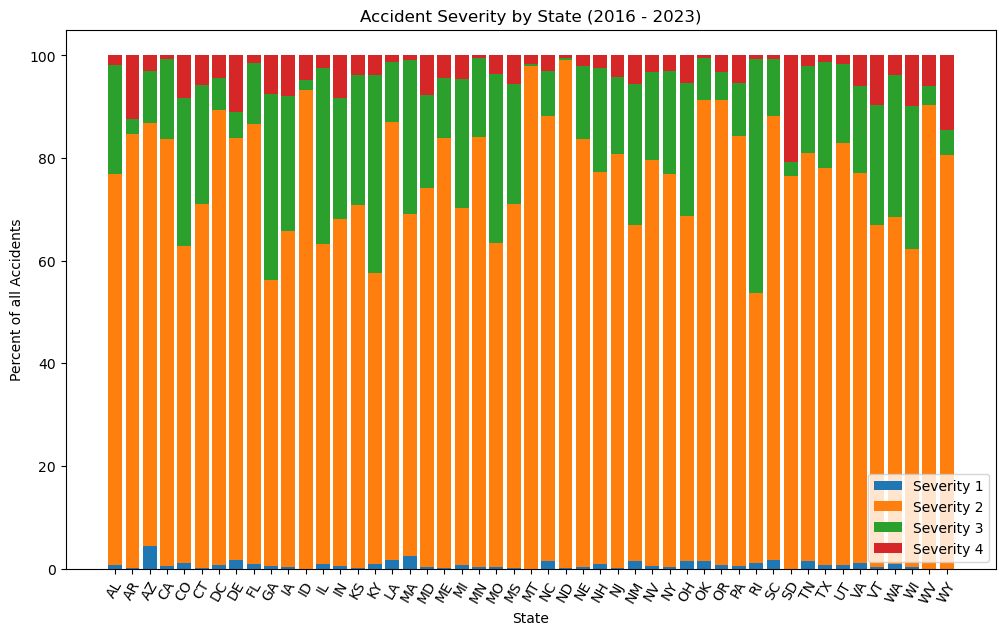

In [4]:
# chart of accident severity by state
states = df_severity_by_state.columns
sev1 = df_severity_by_state.iloc[4]
sev2 = df_severity_by_state.iloc[5]
sev3 = df_severity_by_state.iloc[6]
sev4 = df_severity_by_state.iloc[7]

plt.figure(figsize=(12, 7))
plt.bar(states, sev1)
plt.bar(states, sev2, bottom=sev1)
plt.bar(states, sev3, bottom=sev1+sev2)
plt.bar(states, sev4, bottom=sev1+sev2+sev3)
plt.xlabel("State")
plt.xticks(rotation=60)
plt.ylabel("Percent of all Accidents")
plt.legend(["Severity 1", "Severity 2", "Severity 3", "Severity 4"])
plt.title("Accident Severity by State (2016 - 2023)")
plt.show()

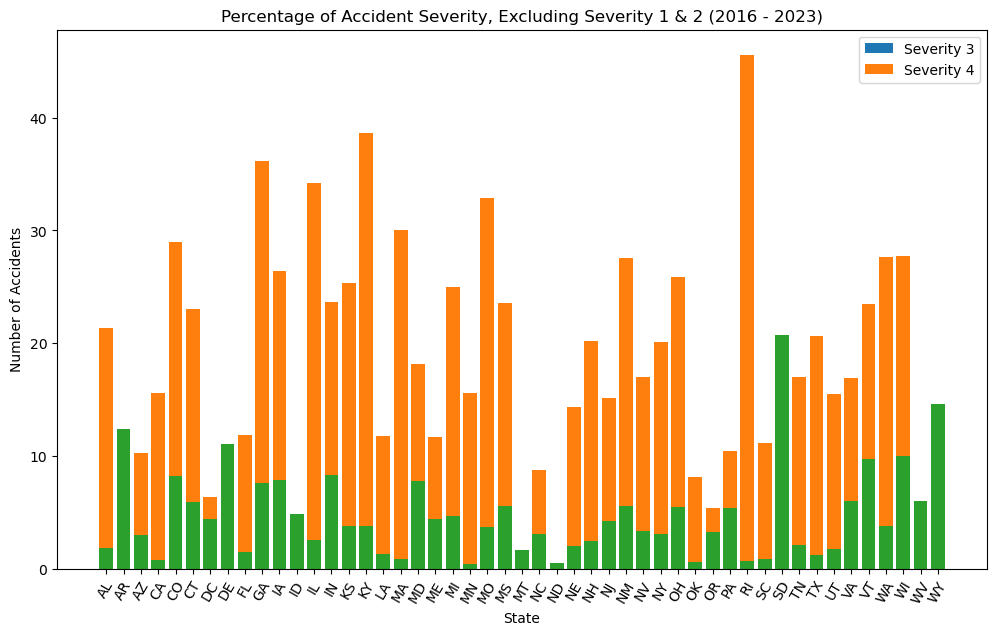

In [5]:
# chart of accident severity by state without sev1 and sev2 (sev 2 >> than the others so obscures sev 1, 3, 4 above)
states = df_severity_by_state.columns
sev3 = df_severity_by_state.iloc[6]
sev4 = df_severity_by_state.iloc[7]

plt.figure(figsize=(12, 7))
plt.bar(states, sev1)
plt.bar(states, sev3)
plt.bar(states, sev4)
plt.xlabel("State")
plt.xticks(rotation=60)
plt.ylabel("Number of Accidents")
plt.legend(["Severity 3", "Severity 4"])
plt.title("Percentage of Accident Severity, Excluding Severity 1 & 2 (2016 - 2023)")
plt.show()

In [6]:
df_sev_by_crossing = pd.crosstab(df_all_data['Severity'], df_all_data['Crossing'])
df_sev_by_crossing = df_sev_by_crossing.rename(columns={False: "No", True: "Yes"})

totals = df_sev_by_crossing.sum()

for i in range(4):
    pct_row1 = (df_sev_by_crossing.iloc[i] / totals) * 100
    df_sev_by_crossing.loc[f'Row{i+1}_pct'] = pct_row1


df_sev_by_crossing

Crossing,No,Yes
Severity,,
1,4.867500e+04,18691.000000
2,5.363435e+06,793546.000000
3,1.251305e+06,48032.000000
4,1.912160e+05,13494.000000
Row1_pct,7.101039e-01,2.139138
Row2_pct,7.824542e+01,90.819364
Row3_pct,1.825488e+01,5.497143
Row4_pct,2.789589e+00,1.544355


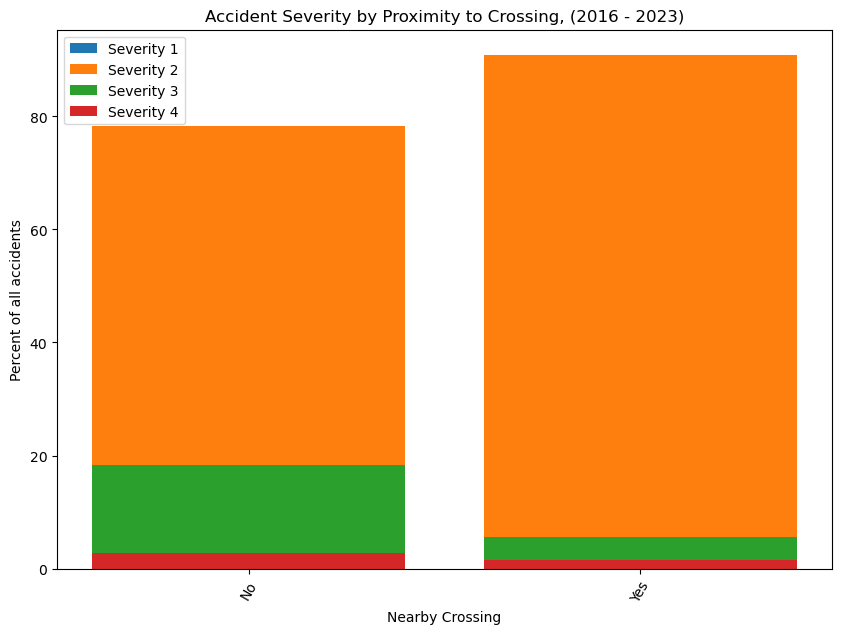

In [7]:
# charts of accident severity by bump, traffic calming, roundabout
# chart of accident severity by state
crossing = df_sev_by_crossing.columns
cr1 = df_sev_by_crossing.iloc[4]
cr2 = df_sev_by_crossing.iloc[5]
cr3 = df_sev_by_crossing.iloc[6]
cr4 = df_sev_by_crossing.iloc[7]

plt.figure(figsize=(10, 7))
plt.bar(crossing, cr1)
plt.bar(crossing, cr2)
plt.bar(crossing, cr3)
plt.bar(crossing, cr4)
plt.xticks(rotation=60)
plt.xlabel("Nearby Crossing")
plt.ylabel("Percent of all accidents")
plt.legend(["Severity 1", "Severity 2", "Severity 3", "Severity 4"])
plt.title("Accident Severity by Proximity to Crossing, (2016 - 2023)")
plt.show()

In [8]:
print(f"Count of Wind Direction Entries: {df_all_data['Wind_Direction'].nunique()}")

Count of Wind Direction Entries: 24


## Data Preparation

### Data Selection

Based on my exploration of the data, I'm dropping the following fields from the dataset for the following reasons:

- Source: contains information that has no relationship to causes and effects of accidents
- Start_Lat, Start_Lng, End_Lat, End_Lng, Street, City, County, State, Zipcode, Country: I'm going to model factors that influence accident severity independent of location.
    - I'll drop Zipcode and State data cleaning and construction since they'll be used for imputation and creating a new field
- Start_Time, End_Time: as with location features, I'm dropping these because I'll model factors independent of time
    - I'll drop Start_Time after imputation
- Description: unstructured text that will not give meaningful results with the planned modeling
- Timezone: duplicates zip/state with less precision
- Street: this field is not standardized and will introduce noise to the modeling
- Country: all data is from the United States so this field is redundant
- Airport_Code: doesn't provide germane information-the exact location where weather conditions are reported is not a variable that can be adjusted
- Weather_Timestamp: not related to the conditions of the accidents in any way
- Wind_Direction: too many unique values; values are also not related to travel directions so it's unlikely they'll  produce clear/actionable conclusions


In [4]:
df_refined = df_all_data.drop(['ID', 'Source', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Description',
                                'Timezone', 'Street', 'City', 'County', 'Country', 'Airport_Code', 'Weather_Timestamp', 'Wind_Direction'], axis=1)

print(df_refined.describe())
print(df_refined.info())
print(df_refined.columns)

           Severity  Distance(mi)  Temperature(F)  Wind_Chill(F)  \
count  7.728394e+06  7.728394e+06    7.564541e+06   5.729375e+06   
mean   2.212384e+00  5.618423e-01    6.166329e+01   5.825105e+01   
std    4.875313e-01  1.776811e+00    1.901365e+01   2.238983e+01   
min    1.000000e+00  0.000000e+00   -8.900000e+01  -8.900000e+01   
25%    2.000000e+00  0.000000e+00    4.900000e+01   4.300000e+01   
50%    2.000000e+00  3.000000e-02    6.400000e+01   6.200000e+01   
75%    2.000000e+00  4.640000e-01    7.600000e+01   7.500000e+01   
max    4.000000e+00  4.417500e+02    2.070000e+02   2.070000e+02   

        Humidity(%)  Pressure(in)  Visibility(mi)  Wind_Speed(mph)  \
count  7.554250e+06  7.587715e+06    7.551296e+06     7.157161e+06   
mean   6.483104e+01  2.953899e+01    9.090376e+00     7.685490e+00   
std    2.282097e+01  1.006190e+00    2.688316e+00     5.424983e+00   
min    1.000000e+00  0.000000e+00    0.000000e+00     0.000000e+00   
25%    4.800000e+01  2.937000e+01    

In [5]:
del df_all_data
gc.collect()

2745

### Data Cleaning

##### Missing Values

I've replaced missing values in the code blocks below. Here's a brief explanation of my approch to each column:

- Temperature, Wind_Chill, Humidity, Pressure, Visibility: imputed based on the mean temp of other accident entries sharing the same day and zip code (or state if there are none in the zip code)
- Precipitation, Wind_Speed: assumed NaN indicates no precipitation/wind and replaced NaN with zero
- Sunrise_Sunset: imputed based on day/night for a 12 hour day
- Civil_Twilight: imputed based on day/night for a 12 hour day
- Nautical_Twilight: imputed based on day/night for a 12 hour day
- Astronomical_Twilight: imputed based on day/night for a 12 hour day

In [6]:
# converting date fields to datetime; extracting date and time into their own columns
df_refined['Start_Time'] = pd.to_datetime(df_refined['Start_Time'], yearfirst=True, format='mixed')
df_refined['End_Time'] = pd.to_datetime(df_refined['End_Time'], yearfirst=True, format='mixed')
df_refined['Acc_date'] = df_refined['Start_Time'].dt.date
df_refined['Acc_time'] = df_refined['Start_Time'].dt.time

The function below fills blank values in temperature wind chill, humidity, pressure and visibility. It imputes the values through a series of steps:

1. it calculates the average temperature on the date of the accident in the same zip code and fills it
2. if there were no other accidents in the same zip code on that day, it calculcates the average temperature in the state and fills it
3. if there were no other accidents in the same  state on that day, it calculates the average temperature across the country and fills it

In [7]:
def impute_nan_vals(df, value, date='Acc_date', zip='Zipcode', state='State'):
    """
    Calculates and saves mean values by zip, state, and dataset. 
    Used in preprocessing to impute missing values.

    - temperature
    - wind chill
    - humidity
    - pressure
    - visibility

    Parameters:
    df: starting dataframe
    date: 'Acc_date', column containing day, month, year of accident
    zip: 'Zipcode', column containing zip codes
    state: 'State', column containing 2-character state abbreviations
    temp: 'Temperature(F)', column containing temperature 
    """

    df_filled = df.copy()

    # step 1: calculate means for each date-zip combination
    value_means_zip = df_filled.groupby([date, zip])[value].transform('mean')
    df_filled[value] = df_filled[value].fillna(value_means_zip)

    #step 2: for remaining NaNs, replace with date-state combination
    if df_filled[value].isna().any():
        remaining = df_filled[value].isna().sum()
        print(f"{remaining} {value} values still missing after date-zip fill.")
        print(f"Filling remaining {value} with date-state mean")

        value_means_state = df_filled.groupby([date, state])[value].transform('mean')
        df_filled[value] = df_filled[value].fillna(value_means_state)

    # step 3: for remaining NaNs, fill with overall mean as a last resort
    if df_filled[value].isna().any():
        remaining = df_filled[value].isna().sum()
        print(f"{remaining} {value} values still missing after date-state fill.")
        print(f"Filling remaining {value} with overall mean")

        df_filled[value] = df_filled[value].fillna(df_filled[value].mean())

    return df_filled

def impute_missing_temps(df_filled, date='Acc_date', zip='Zipcode', state='State', temp='Temperature(F)'):
    """
    Uses impute_nan_values function to fill missing temperature values
    """
    print("Filling missing temperature values.")
    return impute_nan_vals(df_filled, temp, date, zip, state)

def impute_missing_windchill(df_filled, date='Acc_date', zip='Zipcode', state='State', windchill='Wind_Chill(F)'):
    """
    Uses replace_nan_values function to fill missing wind chill values
    """
    print("Filling missing wind chill values.")
    return impute_nan_vals(df_filled, windchill, date, zip, state)

def impute_missing_hum(df_filled, date='Acc_date', zip='Zipcode', state='State', hum='Humidity(%)'):
    """
    Uses replace_nan_values function to fill missing humidity values
    """
    print("Filling missing humidity values.")
    return impute_nan_vals(df_filled, hum, date, zip, state)

def impute_missing_press(df_filled, date='Acc_date', zip='Zipcode', state='State', press='Pressure(in)'):
    """
    Uses replace_nan_values function to fill missing pressure values
    """
    print("Filling missing pressure values.")
    return impute_nan_vals(df_filled, press, date, zip, state)

def impute_missing_vis(df_filled, date='Acc_date', zip='Zipcode', state='State', vis='Visibility(mi)'):
    """
    Uses replace_nan_values function to fill missing visibility values
    """
    print("Filling missing visibility values.")
    return impute_nan_vals(df_filled, vis, date, zip, state)

def impute_missing_weather_data(df_filled, date='Acc_date', zip='Zipcode', state='State', temp='Temperature(F)', windchill='Wind_Chill(F)', 
                                hum='Humidity(%)', press='Pressure(in)', vis='Visibility(mi)'):
    """
    Main data preprocessing function to replace NaN values in weather columns.

    Parameters:
    -----------
    df: dataframe with missing values
    date: date of accident
    zip: zip code of accident
    state: state of accident
    temp: temperature at time of accident
    windchill: wind chill at time of accident
    hum: humidity at time of accident
    press: pressure at time of accident
    vis: visibility at time of accident

    Returns:
    --------
    Dataframe with NaN values replaced with imputed values
    """
    df_filled = impute_missing_temps(df_filled, date, zip, state, temp)

    df_filled = impute_missing_windchill(df_filled, date, zip, state, windchill)

    df_filled = impute_missing_hum(df_filled, date, zip, state, hum)

    df_filled = impute_missing_press(df_filled, date, zip, state, press)

    df_filled = impute_missing_vis(df_filled, date, zip, state, vis)

    return df_filled

In [8]:
df_filled = impute_missing_weather_data(df_refined)

Filling missing temperature values.
158386 Temperature(F) values still missing after date-zip fill.
Filling remaining Temperature(F) with date-state mean
7341 Temperature(F) values still missing after date-state fill.
Filling remaining Temperature(F) with overall mean
Filling missing wind chill values.
1949795 Wind_Chill(F) values still missing after date-zip fill.
Filling remaining Wind_Chill(F) with date-state mean
687931 Wind_Chill(F) values still missing after date-state fill.
Filling remaining Wind_Chill(F) with overall mean
Filling missing humidity values.
166329 Humidity(%) values still missing after date-zip fill.
Filling remaining Humidity(%) with date-state mean
7358 Humidity(%) values still missing after date-state fill.
Filling remaining Humidity(%) with overall mean
Filling missing pressure values.
137561 Pressure(in) values still missing after date-zip fill.
Filling remaining Pressure(in) with date-state mean
7313 Pressure(in) values still missing after date-state fill.
F

In [9]:
# writing NaN-free columns back to working df
df_refined['Temperature(F)'] = df_filled['Temperature(F)']
df_refined['Wind_Chill(F)'] = df_filled['Wind_Chill(F)']
df_refined['Humidity(%)'] = df_filled['Humidity(%)']
df_refined['Pressure(in)'] = df_filled['Pressure(in)']
df_refined['Visibility(mi)'] = df_filled['Visibility(mi)']

# replacing NaN with 0 in wind speed and precipitation
df_refined['Wind_Speed(mph)'] = df_refined['Wind_Speed(mph)'].fillna(0)
df_refined['Precipitation(in)'] = df_refined['Precipitation(in)'].fillna(0)

# checking for remaining NaN entries
print(f"NaN Temperature Entries: {df_refined['Temperature(F)'].isna().sum()}")
print(f"NaN Wind Chill Entries: {df_refined['Wind_Chill(F)'].isna().sum()}")
print(f"NaN Humidity Entries: {df_refined['Humidity(%)'].isna().sum()}")
print(f"NaN Pressure Entries: {df_refined['Pressure(in)'].isna().sum()}")
print(f"NaN Visibility Entries: {df_refined['Visibility(mi)'].isna().sum()}")
print(f"NaN Wind Speed Entries: {df_refined['Wind_Speed(mph)'].isna().sum()}")
print(f"NaN Precipitation Entries: {df_refined['Precipitation(in)'].isna().sum()}")

gc.collect()


NaN Temperature Entries: 0
NaN Wind Chill Entries: 0
NaN Humidity Entries: 0
NaN Pressure Entries: 0
NaN Visibility Entries: 0
NaN Wind Speed Entries: 0
NaN Precipitation Entries: 0


35

In [10]:
# converting boolean to integer
df_refined['Amenity'] = df_refined['Amenity'].astype(int)
df_refined['Bump'] = df_refined['Bump'].astype(int)
df_refined['Crossing'] = df_refined['Crossing'].astype(int)
df_refined['Give_Way'] = df_refined['Give_Way'].astype(int)
df_refined['Junction'] = df_refined['Junction'].astype(int)
df_refined['No_Exit'] = df_refined['No_Exit'].astype(int)
df_refined['Railway'] = df_refined['Railway'].astype(int)
df_refined['Roundabout'] = df_refined['Roundabout'].astype(int)
df_refined['Station'] = df_refined['Station'].astype(int)
df_refined['Stop'] = df_refined['Stop'].astype(int)
df_refined['Traffic_Calming'] = df_refined['Traffic_Calming'].astype(int)
df_refined['Traffic_Signal'] = df_refined['Traffic_Signal'].astype(int)
df_refined['Turning_Loop'] = df_refined['Turning_Loop'].astype(int)

There are a variety of entries missing a day/night entry. I'm imputing that value by adding a column that calculates day or night based on a 12-hour day, then filling that value into any missing entries.

In [11]:
# creating column displaying Day or Night based on a day with equal length days and nights
def day_or_night(t):
    if time(6, 0, 0) <= t < time(18, 0, 0):
        return 'Day'
    else:
        return 'Night'

df_refined['Day_Night_Calc'] = df_refined['Acc_time'].apply(day_or_night)
df_refined['Day_Night_Calc'].value_counts()

Day_Night_Calc
Day      5515796
Night    2212598
Name: count, dtype: int64

In [12]:
df_refined_dup2 = df_refined.copy()
day_night_cols =['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

# replacing missing day/night values with the generic day/night column created above
for col in day_night_cols:
    df_refined_dup2[col] = np.where(df_refined_dup2[col].isna(), df_refined_dup2['Day_Night_Calc'], df_refined_dup2[col])

# verifying that no empty entries remain
blank_counts2 = df_refined_dup2[day_night_cols].isna().sum(axis=1)
results2 = blank_counts2.value_counts().sort_index()
results2

0    7728394
Name: count, dtype: int64

In [13]:
# verifying that no empty entries remain
blank_counts2 = df_refined_dup2[day_night_cols].isna().sum(axis=1)
results2 = blank_counts2.value_counts().sort_index()
results2

0    7728394
Name: count, dtype: int64

In [14]:
# writing day/night column values back to the main df 
df_refined['Sunrise_Sunset'] = df_refined_dup2['Sunrise_Sunset']
df_refined['Civil_Twilight'] = df_refined_dup2['Civil_Twilight']
df_refined['Nautical_Twilight'] = df_refined_dup2['Nautical_Twilight']
df_refined['Astronomical_Twilight'] = df_refined_dup2['Astronomical_Twilight']

In [15]:
del df_refined_dup2
del results2
gc.collect() 

0

#### Cleaning Weather Condition

The Weather_Condition field has a large number of values across the dataset. Many of these values are used rarely and will complicate modeling, so I'll consolidate them into a smaller number of value options. This will be a manual process-I'll review and create a mapping table by hand.

In [16]:
#print(f"Count of Unique Weather Condition Entries: {df_all_data['Weather_Condition'].nunique()}")
df_refined['Weather_Condition'].value_counts().sort_values(ascending=True)

Weather_Condition
Drifting Snow                1
Dust Whirls                  1
Heavy Smoke                  1
Partial Fog / Windy          1
Blowing Snow Nearby          1
                        ...   
Partly Cloudy           698972
Clear                   808743
Cloudy                  817082
Mostly Cloudy          1016195
Fair                   2560802
Name: count, Length: 144, dtype: int64

In [17]:
# printing a list of weather condition unique values to csv
unique_wthr_cond = pd.Series(df_refined['Weather_Condition'].unique())
unique_wthr_cond.to_csv('conditions.csv')

In [18]:
def csv_to_dict_reader(filename):
    result = {}
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            if len(row) >=2:
                result[row[0]] = row[1]
    return result

In [19]:
weather_mapper = csv_to_dict_reader('conditions_consolidated.csv')
df_refined_dup1 = df_refined.copy()

df_refined_dup1['Weather_Condition'] = df_refined_dup1['Weather_Condition'].map(weather_mapper)
print(df_refined_dup1['Weather_Condition'].value_counts().sort_values(ascending=False))
print(df_refined_dup1['Weather_Condition'].nunique())

Weather_Condition
Fair                         3408468
Cloudy                       2249686
Partly Cloudy                 915556
Light Rain                    402997
Light Snow                    135662
Fog                            99981
Rain                           87340
Hazy                           77828
Heavy Rain                     33843
Light Thunderstorm             22545
Thunderstorm                   21501
Tornado                        17664
Snow                           16850
Heavy Thunderstorm             13259
Wintry  Mix                    12768
Smoke                          12764
Light Fog                       7271
Heavy Snow                      5922
Light Sleet                     5319
Mist                            3554
Blowing Snow                    1673
Light Freezing Fog              1001
Blowing Ash / Dust / Sand        769
Sleet                            319
Freezing Rain                    262
Hail                             133
Name: count, dtype: 

In [20]:
df_refined['Weather_Condition'] = df_refined_dup1['Weather_Condition']
df_refined['Weather_Condition'].nunique()

26

In [21]:
del df_refined_dup1
gc.collect()

0

In [22]:
df_refined.columns

Index(['Severity', 'Start_Time', 'End_Time', 'Distance(mi)', 'State',
       'Zipcode', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Acc_date', 'Acc_time', 'Day_Night_Calc'],
      dtype='object')

In [23]:
# removing fields created for cleaning and used for imputation and construction 
df_cleaned = df_refined.drop(['Start_Time', 'End_Time', 'State', 'Zipcode', 'Distance(mi)'], axis=1)

In [24]:
df_encoded = pd.get_dummies(df_cleaned, columns=['Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 
                                                 'Nautical_Twilight', 'Astronomical_Twilight'], drop_first=True)

In [25]:
del df_cleaned
gc.collect()

0

In [26]:
df_encoded.columns

Index(['Severity', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Acc_date',
       'Acc_time', 'Day_Night_Calc', 'Weather_Condition_Blowing Snow',
       'Weather_Condition_Cloudy', 'Weather_Condition_Fair',
       'Weather_Condition_Fog', 'Weather_Condition_Freezing Rain',
       'Weather_Condition_Hail', 'Weather_Condition_Hazy',
       'Weather_Condition_Heavy Rain', 'Weather_Condition_Heavy Snow',
       'Weather_Condition_Heavy Thunderstorm', 'Weather_Condition_Light Fog',
       'Weather_Condition_Light Freezing Fog', 'Weather_Condition_Light Rain',
       'Weather_Condition_Light Sleet', 'Weather_Condition_Light Snow',
       'Weather_Condition_Light Thunderstorm', 'Weather_Condition_Mist',
       'Weather_Conditi

In [27]:
# setting X and y
weather_quant_cols = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 
               'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
weather_qual_cols = ['Weather_Condition_Blowing Snow',
               'Weather_Condition_Cloudy', 'Weather_Condition_Fair',
               'Weather_Condition_Fog', 'Weather_Condition_Freezing Rain',
               'Weather_Condition_Hail', 'Weather_Condition_Hazy',
               'Weather_Condition_Heavy Rain', 'Weather_Condition_Heavy Snow',
               'Weather_Condition_Heavy Thunderstorm', 'Weather_Condition_Light Fog',
               'Weather_Condition_Light Freezing Fog', 'Weather_Condition_Light Rain',
               'Weather_Condition_Light Sleet', 'Weather_Condition_Light Snow',
               'Weather_Condition_Light Thunderstorm', 'Weather_Condition_Mist',
               'Weather_Condition_Partly Cloudy', 'Weather_Condition_Rain',
               'Weather_Condition_Sleet', 'Weather_Condition_Smoke',
               'Weather_Condition_Snow', 'Weather_Condition_Thunderstorm',
               'Weather_Condition_Tornado', 'Weather_Condition_Wintry  Mix']
infrastructure_cols = ['Amenity', 'Bump', 'Crossing', 'Give_Way',
                        'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 
                        'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']
daypart_cols= ['Sunrise_Sunset_Night', 'Civil_Twilight_Night', 
               'Nautical_Twilight_Night', 'Astronomical_Twilight_Night']

X_weather_quant = df_encoded[weather_quant_cols]
X_weather_qual = df_encoded[weather_qual_cols]
X_infrastructure = df_encoded[infrastructure_cols]
X_daypart = df_encoded[daypart_cols]
y = df_encoded['Severity']

# splitting data
X_weather_quant_train, X_weather_quant_test, y_train, y_test = train_test_split(
   X_weather_quant, y, test_size=0.2, random_state=42)

X_weather_qual_train, X_weather_qual_test = train_test_split(
   X_weather_qual, test_size=0.2, random_state=42)

X_infrastructure_train, X_infrastructure_test = train_test_split(
   X_infrastructure, test_size=0.2, random_state=42)

X_daypart_train, X_daypart_test = train_test_split(
   X_daypart, test_size=0.2, random_state=42)

## Analysis

Now that the data is preprocessed, we can move to the analysis. As mentioned earlier, I selected a decision tree model in order to maximize the interpretability of the results. Interpretability is my priority because of the need to deliver clear busines insights; if the goal was to create an accurate predictive model, I would likely have chosen a different approach.

I'll create 4 models to explore the following features and their impact on accident severity:

1. quantitative weather conditions
2. qualitative weather conditions
3. road infrastructure near accident locations
4. day/night at the time of accident (calculated 3 ways)

I'll start by creating and optimizing a model for each the quantitative weather features.

In [29]:
# initializing a baseline model for quantitative weather features
base_model_weather_quant = DecisionTreeClassifier(random_state=42)

# cross-validation
base_scores_weather_quant = cross_val_score(base_model_weather_quant, X_weather_quant_train, 
                              y_train, cv=5, scoring='accuracy')

# fit baseline model to explore feature importance
base_model_weather_quant.fit(X_weather_quant_train, y_train)
initial_importance_weather_quant = pd.DataFrame({
    'feature': X_weather_quant.columns,
    'importance': base_model_weather_quant.feature_importances_
}).sort_values('importance', ascending=False)

print("Baseline model performance")
print(f"Accuracy: {base_scores_weather_quant.mean():.4f}(+/- {base_scores_weather_quant.std() * 2:.4f})")
print(f"Training Score: {base_model_weather_quant.score(X_weather_quant_train, y_train):.4f}")

print("\nInitial Feature Importance:")
print(initial_importance_weather_quant)

Baseline model performance
Accuracy: 0.7532(+/- 0.0005)
Training Score: 0.9237

Initial Feature Importance:
             feature  importance
3       Pressure(in)    0.276711
2        Humidity(%)    0.223298
1      Wind_Chill(F)    0.156333
0     Temperature(F)    0.153789
5    Wind_Speed(mph)    0.117078
4     Visibility(mi)    0.053791
6  Precipitation(in)    0.018999


The baseline model is overfitting: its accuracy on training data is 92% vs. 75% on test (i.e. unseen) data.

I'll next look for optimal parameters for this model. I'll start with a random search to explore a large parameter space, based on probability distributions around each parameter.

In [30]:
# memory management
gc.collect()

# Define parameter distributions for random search
param_dist_1 = {
   # uniform distribution from 1 to 20 for max_depth
   'max_depth': randint(1, 20),
  
   # log-uniform distribution from 2 to 50 for min_samples_split
   'min_samples_split': reciprocal(a=2, b=50).rvs(1000).round().astype(int),
  
   # log-uniform distribution from 1 to 20 for min_samples_leaf
   'min_samples_leaf': reciprocal(a=1, b=20).rvs(1000).round().astype(int),
  
   # categorical distribution for criterion
   'criterion': ['gini', 'entropy']
}

# Initialize randomized search
random_search_weather_quant = RandomizedSearchCV(
   DecisionTreeClassifier(random_state=42),
   param_distributions=param_dist_1,
   n_iter=100,  # Number of parameter settings sampled
   cv=5,
   scoring='accuracy',
   n_jobs=-1,
   random_state=42
)

# Perform random search
random_search_weather_quant.fit(X_weather_quant_train, y_train)


print("Best parameters from random search:")
print(random_search_weather_quant.best_params_)
print(f"Best cross-validation score: {random_search_weather_quant.best_score_:.3f}")
print(f"Best training score: {random_search_weather_quant.best_estimator_.score(X_weather_quant_train, y_train):.3f}")

Best parameters from random search:
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 19, 'min_samples_split': 3}
Best cross-validation score: 0.797
Best training score: 0.797


I'll now perform a more focused parameter search using grid search. The best values from the random search inform the grid values below.

In [31]:
# memory management
gc.collect()

focused_param_grid_1 = {
  'criterion': ['gini'],
  'max_depth': [5, 6, 7],
  'min_samples_leaf': [18, 19, 20],
  'min_samples_split': [2, 3, 4]
}

# Perform grid search
grid_search_weather_quant = GridSearchCV(
   DecisionTreeClassifier(random_state=42),
   focused_param_grid_1,
   cv=5,
   scoring='accuracy',
   n_jobs=-1
)

grid_search_weather_quant.fit(X_weather_quant_train, y_train)

print("Best parameters from grid search:")
print(grid_search_weather_quant.best_params_)
print(f"Best cross-validation score: {grid_search_weather_quant.best_score_:.3f}")
print(f"Best training score: {grid_search_weather_quant.best_estimator_.score(X_weather_quant_train, y_train):.3f}")

Best parameters from grid search:
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 2}
Best cross-validation score: 0.797
Best training score: 0.797


Grid search gave us parameters that result in identical training and validation scores (0.797). Although the value is lower than ideal, these scores indicate the model with these parameters is neither over nor underfitting.

In [28]:
# final model for quantitative weather features
final_model_weather_quant = DecisionTreeClassifier(random_state=42,
                                                   criterion='gini',
                                                   max_depth=6,
                                                   min_samples_leaf=18,
                                                   min_samples_split=2)

# cross-validation
final_scores_weather_quant = cross_val_score(final_model_weather_quant, X_weather_quant_train, 
                              y_train, cv=5, scoring='accuracy')

# fit final model to see feature importance
final_model_weather_quant.fit(X_weather_quant_train, y_train)
final_importance_weather_quant = pd.DataFrame({
    'feature': X_weather_quant.columns,
    'importance': final_model_weather_quant.feature_importances_
}).sort_values('importance', ascending=False)

print("Final model performance")
print(f"Accuracy: {final_scores_weather_quant.mean():.4f}(+/- {final_scores_weather_quant.std() * 2:.4f})")
print(f"Training Score: {final_model_weather_quant.score(X_weather_quant_train, y_train):.4f}")

print("\nFinal Feature Importance:")
print(final_importance_weather_quant)



Final model performance
Accuracy: 0.7969(+/- 0.0000)
Training Score: 0.7969

Final Feature Importance:
             feature  importance
1      Wind_Chill(F)    0.366455
0     Temperature(F)    0.223525
3       Pressure(in)    0.218355
5    Wind_Speed(mph)    0.159344
2        Humidity(%)    0.022154
4     Visibility(mi)    0.005095
6  Precipitation(in)    0.005072


Next, I'll model the effect of qualitative weather designations on accident severity, starting with a baseline model.

In [33]:
# initializing a baseline model for qualitative weather features
base_model_weather_qual = DecisionTreeClassifier(random_state=42)

# cross-validation
base_scores_weather_qual = cross_val_score(base_model_weather_qual, X_weather_qual_train, 
                              y_train, cv=5, scoring='accuracy')

# fit baseline model to explore feature importance
base_model_weather_qual.fit(X_weather_qual_train, y_train)
initial_importance_weather_qual = pd.DataFrame({
    'feature': X_weather_qual.columns,
    'importance': base_model_weather_qual.feature_importances_
}).sort_values('importance', ascending=False)

print("Baseline model performance")
print(f"Accuracy: {base_scores_weather_qual.mean():.4f}(+/- {base_scores_weather_qual.std() * 2:.4f})")
print(f"Training Score: {base_model_weather_qual.score(X_weather_qual_train, y_train):.4f}")

print("\nInitial Feature Importance:")
print(initial_importance_weather_qual)

Baseline model performance
Accuracy: 0.7968(+/- 0.0000)
Training Score: 0.7968

Initial Feature Importance:
                                 feature  importance
2                 Weather_Condition_Fair    0.645059
3                  Weather_Condition_Fog    0.150811
17       Weather_Condition_Partly Cloudy    0.100004
24         Weather_Condition_Wintry  Mix    0.021326
12          Weather_Condition_Light Rain    0.018072
18                Weather_Condition_Rain    0.015366
13         Weather_Condition_Light Sleet    0.010305
7           Weather_Condition_Heavy Rain    0.007889
14          Weather_Condition_Light Snow    0.005235
8           Weather_Condition_Heavy Snow    0.003352
21                Weather_Condition_Snow    0.002853
20               Weather_Condition_Smoke    0.002851
6                 Weather_Condition_Hazy    0.002842
22        Weather_Condition_Thunderstorm    0.002426
0         Weather_Condition_Blowing Snow    0.002383
9   Weather_Condition_Heavy Thunderstorm    

The baseline model does not have the strongest accuracy, but its similarity to the validation accuracy indicates a well-fit model. 

Next we'll optimize parameters, starting with random search.

In [34]:
# memory management
gc.collect()

# Define parameter distributions for random search
param_dist_2 = {
   # uniform distribution from 1 to 20 for max_depth
   'max_depth': randint(1, 20),
  
   # log-uniform distribution from 2 to 50 for min_samples_split
   'min_samples_split': reciprocal(a=2, b=50).rvs(1000).round().astype(int),
  
   # log-uniform distribution from 1 to 20 for min_samples_leaf
   'min_samples_leaf': reciprocal(a=1, b=20).rvs(1000).round().astype(int),
  
   # categorical distribution for criterion
   'criterion': ['gini', 'entropy']
}

# Initialize randomized search
random_search_weather_qual = RandomizedSearchCV(
   DecisionTreeClassifier(random_state=42),
   param_distributions=param_dist_2,
   n_iter=100,  # Number of parameter settings sampled
   cv=5,
   scoring='accuracy',
   n_jobs=-1,
   random_state=42
)

# Perform random search
random_search_weather_qual.fit(X_weather_qual_train, y_train)


print("Best parameters from random search:")
print(random_search_weather_qual.best_params_)
print(f"Best cross-validation score: {random_search_weather_qual.best_score_:.3f}")
print(f"Best training score: {random_search_weather_qual.best_estimator_.score(X_weather_qual_train, y_train):.3f}")

Best parameters from random search:
{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 7, 'min_samples_split': 2}
Best cross-validation score: 0.797
Best training score: 0.797


The best parameters from random search left accuracy scores essentially unchanged. Although it's unlikely to change much, I'll do a grid search next to ensure I have optimal parameters.

In [35]:
# memory management
gc.collect()

focused_param_grid_2 = {
  'criterion': ['gini'],
  'max_depth': [13, 15, 17],
  'min_samples_leaf': [6, 7, 8],
  'min_samples_split': [2, 3, 4]
}

# Perform grid search
grid_search_weather_qual = GridSearchCV(
   DecisionTreeClassifier(random_state=42),
   focused_param_grid_2,
   cv=5,
   scoring='accuracy',
   n_jobs=-1
)

grid_search_weather_qual.fit(X_weather_qual_train, y_train)

print("Best parameters from grid search:")
print(grid_search_weather_qual.best_params_)
print(f"Best cross-validation score: {grid_search_weather_qual.best_score_:.3f}")
print(f"Best training score: {grid_search_weather_qual.best_estimator_.score(X_weather_qual_train, y_train):.3f}")

Best parameters from grid search:
{'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 6, 'min_samples_split': 2}
Best cross-validation score: 0.797
Best training score: 0.797


The final training and validation scores are the same and very similar to the baseline model scores.

In [31]:
# final model for qualitative weather features
final_model_weather_qual = DecisionTreeClassifier(random_state=42,
                                                  criterion='gini',
                                                  max_depth=13, 
                                                  min_samples_leaf=6,
                                                  min_samples_split=2)

# cross-validation
final_scores_weather_qual = cross_val_score(final_model_weather_qual, X_weather_qual_train, 
                              y_train, cv=5, scoring='accuracy')

# fit final model to explore feature importance
final_model_weather_qual.fit(X_weather_qual_train, y_train)
final_importance_weather_qual = pd.DataFrame({
    'feature': X_weather_qual.columns,
    'importance': final_model_weather_qual.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print("Final model performance")
print(f"Accuracy: {final_scores_weather_qual.mean():.4f}(+/- {final_scores_weather_qual.std() * 2:.4f})")
print(f"Training Score: {final_model_weather_qual.score(X_weather_qual_train, y_train):.4f}")

print("\nFinal Feature Importance (top 10):")
print(final_importance_weather_qual)

Final model performance
Accuracy: 0.7968(+/- 0.0000)
Training Score: 0.7968

Final Feature Importance (top 10):
                            feature  importance
2            Weather_Condition_Fair    0.654241
3             Weather_Condition_Fog    0.152957
17  Weather_Condition_Partly Cloudy    0.101428
24    Weather_Condition_Wintry  Mix    0.021630
12     Weather_Condition_Light Rain    0.018329
18           Weather_Condition_Rain    0.015585
13    Weather_Condition_Light Sleet    0.010452
7      Weather_Condition_Heavy Rain    0.008002
14     Weather_Condition_Light Snow    0.005310
8      Weather_Condition_Heavy Snow    0.003400


Next we'll look at the effect of road infrastructure on accident severity.

In [27]:
# initializing a baseline model for road infrastructure features
base_model_infra = DecisionTreeClassifier(random_state=42)

# cross-validation
base_scores_infra = cross_val_score(base_model_infra, X_infrastructure_train, 
                              y_train, cv=5, scoring='accuracy')

# fit baseline model to explore feature importance
base_model_infra.fit(X_infrastructure_train, y_train)
initial_importance_infra = pd.DataFrame({
    'feature': X_infrastructure_train.columns,
    'importance': base_model_infra.feature_importances_
}).sort_values('importance', ascending=False)

print("Baseline model performance")
print(f"Accuracy: {base_scores_infra.mean():.4f}(+/- {base_scores_infra.std() * 2:.4f})")
print(f"Training Score: {base_model_infra.score(X_infrastructure_train, y_train):.4f}")

print("\nInitial Feature Importance:")
print(initial_importance_infra)

Baseline model performance
Accuracy: 0.7969(+/- 0.0000)
Training Score: 0.7969

Initial Feature Importance:
            feature  importance
2          Crossing    0.471948
11   Traffic_Signal    0.208544
9              Stop    0.122418
4          Junction    0.059304
6           Railway    0.052567
8           Station    0.045541
0           Amenity    0.026048
3          Give_Way    0.005025
5           No_Exit    0.004149
10  Traffic_Calming    0.002109
1              Bump    0.001921
7        Roundabout    0.000426
12     Turning_Loop    0.000000


Refining parameters using random search:

In [28]:
# memory management
gc.collect()

# Define parameter distributions for random search
param_dist_3 = {
   # uniform distribution from 1 to 20 for max_depth
   'max_depth': randint(1, 20),
  
   # log-uniform distribution from 2 to 50 for min_samples_split
   'min_samples_split': reciprocal(a=2, b=50).rvs(1000).round().astype(int),
  
   # log-uniform distribution from 1 to 20 for min_samples_leaf
   'min_samples_leaf': reciprocal(a=1, b=20).rvs(1000).round().astype(int),
  
   # categorical distribution for criterion
   'criterion': ['gini', 'entropy']
}

# Initialize randomized search
random_search_infra = RandomizedSearchCV(
   DecisionTreeClassifier(random_state=42),
   param_distributions=param_dist_3,
   n_iter=100,  # Number of parameter settings sampled
   cv=5,
   scoring='accuracy',
   n_jobs=-1,
   random_state=42
)

# Perform random search
random_search_infra.fit(X_infrastructure_train, y_train)


print("Best parameters from random search:")
print(random_search_infra.best_params_)
print(f"Best cross-validation score: {random_search_infra.best_score_:.3f}")
print(f"Best training score: {random_search_infra.best_estimator_.score(X_infrastructure_train, y_train):.3f}")

Best parameters from random search:
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 15}
Best cross-validation score: 0.797
Best training score: 0.797


Training and cross-val scores changed very little; for completeness I'll do a grid search to refine parameters.

In [30]:
# memory management
gc.collect()

focused_param_grid_3 = {
  'criterion': ['gini'],
  'max_depth': [7, 8, 9],
  'min_samples_leaf': [2, 3],
  'min_samples_split': [13, 15, 17]
}

# Perform grid search
grid_search_infra = GridSearchCV(
   DecisionTreeClassifier(random_state=42),
   focused_param_grid_3,
   cv=5,
   scoring='accuracy',
   n_jobs=-1
)

grid_search_infra.fit(X_infrastructure_train, y_train)

print("Best parameters from grid search:")
print(grid_search_infra.best_params_)
print(f"Best cross-validation score: {grid_search_infra.best_score_:.3f}")
print(f"Best training score: {grid_search_infra.best_estimator_.score(X_infrastructure_train, y_train):.3f}")

Best parameters from grid search:
{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 13}
Best cross-validation score: 0.797
Best training score: 0.797


As with other models, the final model's scores are very similar to the baseline model scores.

In [33]:
# final model for road infrastructure features
final_model_infra = DecisionTreeClassifier(random_state=42,
                                           criterion='gini',
                                           max_depth=8,
                                           min_samples_leaf=2,
                                           min_samples_split=13)

# cross-validation
final_scores_infra = cross_val_score(final_model_infra, X_infrastructure_train, 
                              y_train, cv=5, scoring='accuracy')

# fit final model to explore feature importance
final_model_infra.fit(X_infrastructure_train, y_train)
final_importance_infra = pd.DataFrame({
    'feature': X_infrastructure_train.columns,
    'importance': final_model_infra.feature_importances_
}).sort_values('importance', ascending=False)

print("Final model performance")
print(f"Accuracy: {final_scores_infra.mean():.4f}(+/- {final_scores_infra.std() * 2:.4f})")
print(f"Training Score: {final_model_infra.score(X_infrastructure_train, y_train):.4f}")

print("\nFinal Feature Importance:")
print(final_importance_infra)

Final model performance
Accuracy: 0.7969(+/- 0.0000)
Training Score: 0.7969

Final Feature Importance:
            feature  importance
2          Crossing    0.474225
11   Traffic_Signal    0.209550
9              Stop    0.122917
4          Junction    0.059568
6           Railway    0.050337
8           Station    0.045708
0           Amenity    0.025537
3          Give_Way    0.004418
5           No_Exit    0.003669
10  Traffic_Calming    0.001937
1              Bump    0.001799
7        Roundabout    0.000335
12     Turning_Loop    0.000000


Finally, I'll model the effect of day part on accident severity.

In [33]:
# initializing a baseline model for daypart features
base_model_daypart = DecisionTreeClassifier(random_state=42)

# cross-validation
base_scores_daypart = cross_val_score(base_model_daypart, X_daypart_train, 
                              y_train, cv=5, scoring='accuracy')

# fit baseline model to explore feature importance
base_model_daypart.fit(X_daypart_train, y_train)
initial_importance_daypart = pd.DataFrame({
    'feature': X_daypart.columns,
    'importance': base_model_daypart.feature_importances_
}).sort_values('importance', ascending=False)

print("Baseline model performance")
print(f"Accuracy: {base_scores_daypart.mean():.4f}(+/- {base_scores_daypart.std() * 2:.4f})")
print(f"Training Score: {base_model_daypart.score(X_daypart_train, y_train):.4f}")

print("\nInitial Feature Importance:")
print(initial_importance_daypart)

Baseline model performance
Accuracy: 0.7968(+/- 0.0000)
Training Score: 0.7968

Initial Feature Importance:
                       feature  importance
3  Astronomical_Twilight_Night    0.943144
2      Nautical_Twilight_Night    0.052546
0         Sunrise_Sunset_Night    0.003035
1         Civil_Twilight_Night    0.001275


Refining hyperparameters with a random search:

In [34]:
# memory management
gc.collect()

# Define parameter distributions for random search
param_dist_4 = {
   # uniform distribution from 1 to 20 for max_depth
   'max_depth': randint(1, 20),
  
   # log-uniform distribution from 2 to 50 for min_samples_split
   'min_samples_split': reciprocal(a=2, b=50).rvs(1000).round().astype(int),
  
   # log-uniform distribution from 1 to 20 for min_samples_leaf
   'min_samples_leaf': reciprocal(a=1, b=20).rvs(1000).round().astype(int),
  
   # categorical distribution for criterion
   'criterion': ['gini', 'entropy']
}

# Initialize randomized search
random_search_daypart = RandomizedSearchCV(
   DecisionTreeClassifier(random_state=42),
   param_distributions=param_dist_3,
   n_iter=100,  # Number of parameter settings sampled
   cv=5,
   scoring='accuracy',
   n_jobs=-1,
   random_state=42
)

# Perform random search
random_search_daypart.fit(X_daypart_train, y_train)

print("Best parameters from random search:")
print(random_search_daypart.best_params_)
print(f"Best cross-validation score: {random_search_daypart.best_score_:.3f}")
print(f"Best training score: {random_search_daypart.best_estimator_.score(X_daypart_train, y_train):.3f}")

Best parameters from random search:
{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 6}
Best cross-validation score: 0.797
Best training score: 0.797


A final grid search to land on final parameters:

In [35]:
# memory management
gc.collect()

focused_param_grid_4 = {
  'criterion': ['gini'],
  'max_depth': [13, 15, 17],
  'min_samples_leaf': [3, 4, 5],
  'min_samples_split': [5, 6, 7]
}

# Perform grid search
grid_search_daypart = GridSearchCV(
   DecisionTreeClassifier(random_state=42),
   focused_param_grid_4,
   cv=5,
   scoring='accuracy',
   n_jobs=-1
)

grid_search_daypart.fit(X_daypart_train, y_train)

print("Best parameters from grid search:")
print(grid_search_daypart.best_params_)
print(f"Best cross-validation score: {grid_search_daypart.best_score_:.3f}")
print(f"Best training score: {grid_search_daypart.best_estimator_.score(X_daypart_train, y_train):.3f}")

Best parameters from grid search:
{'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 3, 'min_samples_split': 5}
Best cross-validation score: 0.797
Best training score: 0.797


In [34]:
# final model for daypart features
final_model_daypart = DecisionTreeClassifier(random_state=42,
                                             criterion='gini',
                                             max_depth=13,
                                             min_samples_leaf=3,
                                             min_samples_split=5)

# cross-validation
final_scores_daypart = cross_val_score(final_model_daypart, X_daypart_train, 
                              y_train, cv=5, scoring='accuracy')

# fit final model to explore feature importance
final_model_daypart.fit(X_daypart_train, y_train)
final_importance_daypart = pd.DataFrame({
    'feature': X_daypart.columns,
    'importance': final_model_daypart.feature_importances_
}).sort_values('importance', ascending=False)

print("Final model performance")
print(f"Accuracy: {final_scores_daypart.mean():.4f}(+/- {final_scores_daypart.std() * 2:.4f})")
print(f"Training Score: {final_model_daypart.score(X_daypart_train, y_train):.4f}")

print("\nFinal Feature Importance:")
print(final_importance_daypart)

Final model performance
Accuracy: 0.7968(+/- 0.0000)
Training Score: 0.7968

Final Feature Importance:
                       feature  importance
3  Astronomical_Twilight_Night    0.943144
2      Nautical_Twilight_Night    0.052546
0         Sunrise_Sunset_Night    0.003035
1         Civil_Twilight_Night    0.001275


## Evaluation

### Insight 1: Weather Conditions Have a Largely Counterintuitive Effect on Accident Severity

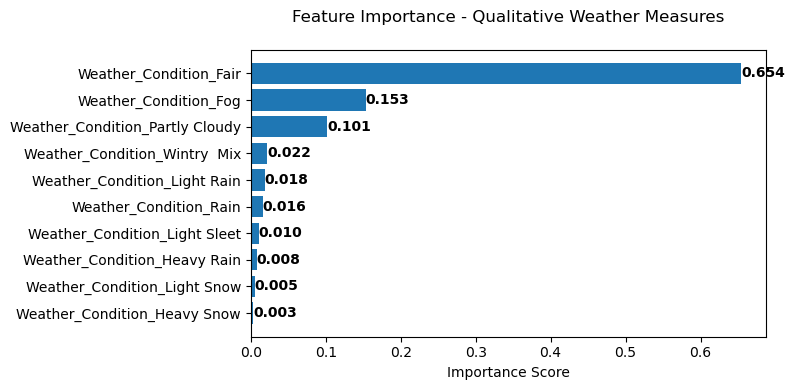

In [46]:
plt.figure(figsize= (8, 4))

final_importance_weather_qual_sorted = final_importance_weather_qual.sort_values(by='importance', ascending=True)

bars = plt.barh(final_importance_weather_qual_sorted['feature'], 
                final_importance_weather_qual_sorted['importance'])
plt.title('Feature Importance - Qualitative Weather Measures', pad=20)
plt.xlabel('Importance Score')

# value labels on the bars for precise reading
for bar in bars:
   width = bar.get_width()
   plt.text(width, bar.get_y() + bar.get_height()/2,
            f'{width:.3f}',
            ha='left', va='center',
            fontweight='bold')

plt.tight_layout()
plt.show()

As the chart above shows, conditions such as snow and rain do not increase the likelihood of severe accidents nearly as much as fair weather. While initially surprising, this conclusion is explicable with further scrutiny.

It appears that drivers respond to snow and rain by driving more cautiously and attentively, thereby reducing the likelihood of more severe accidents. By this logic, fair weather conditions mean drivers are less cautious and attentive, thereby increasing the severity of accidents.

Foggy conditions also increase the likelihood of severe accidents, which also aligns to this theory. Fog reduces visibility, which likely has a similar effect on safety as a distracted driver.

#### Recommendation ####

Public education messaging about safe driving should emphasise the significance of attention when it comes to driving safety. These findings can be excerpted to help drivers understand that most serious accidents happen in clear weather and are likely caused by inattention or unsafe driving.

### Insight 2



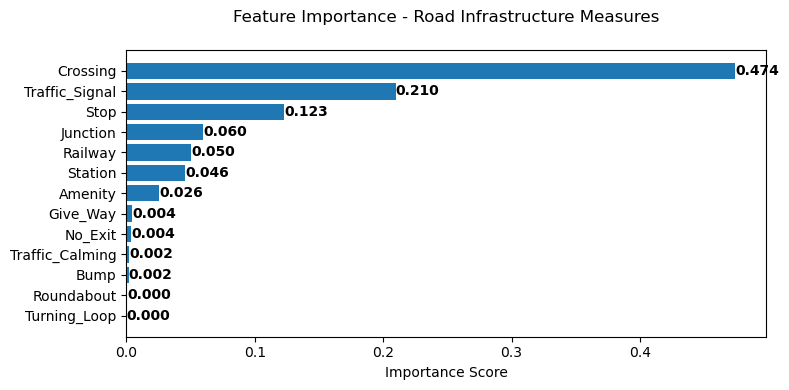

In [47]:
plt.figure(figsize= (8, 4))

final_importance_infra_sorted = final_importance_infra.sort_values(by='importance', ascending=True)

bars = plt.barh(final_importance_infra_sorted['feature'], 
                final_importance_infra_sorted['importance'])
plt.title('Feature Importance - Road Infrastructure Measures', pad=20)
plt.xlabel('Importance Score')

# value labels on the bars for precise reading
for bar in bars:
   width = bar.get_width()
   plt.text(width, bar.get_y() + bar.get_height()/2,
            f'{width:.3f}',
            ha='left', va='center',
            fontweight='bold')

plt.tight_layout()
plt.show()

The chart above shows that pedestrian crossings, traffic signals, and stop signs are the 3 factors that contribute most to accident severity. Similarly, traffic calming devices, bumps, and roundabouts are 3 of the 4 factors that contribute the least to accident severity.

#### Recommendation ####

Taken together, the largest and smallest contributors point to 3 things:

1. Replacing stop signs and traffic lights with roundabouts would likely decrease accident severity in a meaningful way.
2. Prevention and driver education efforts would have the most impact if focused on high-traffic pedestrian crossings, traffic signals, and stop signs.
3. Longer-term infrastructure planning should include raffic control structures such as give ways, turning loops, and bumps whenever possible, given their inverse relationship to accident severity.

### Insight 3: Dawn and Dusk are Higher-Risk Times for Accident Severity

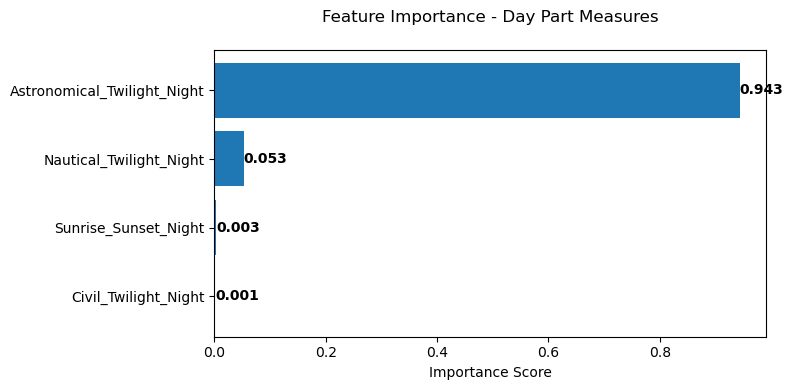

In [48]:
plt.figure(figsize= (8, 4))

final_importance_daypart_sorted = final_importance_daypart.sort_values(by='importance', ascending=True)

bars = plt.barh(final_importance_daypart_sorted['feature'], 
                final_importance_daypart_sorted['importance'])
plt.title('Feature Importance - Day Part Measures', pad=20)
plt.xlabel('Importance Score')

# value labels on the bars for precise reading
for bar in bars:
   width = bar.get_width()
   plt.text(width, bar.get_y() + bar.get_height()/2,
            f'{width:.3f}',
            ha='left', va='center',
            fontweight='bold')

plt.tight_layout()
plt.show()

An interesting and unexpected finding was how time of day impacts accident severity. First, though, some quick definitions:

- Sunrise/sunset night: begins when the sun disappears below the horizon
- Civil twilight night: occurs between sunset and when the sun is 6 degrees below the horizon
- Naughtical twilight night: occurs when the sun is between 6 and 12 degrees below the horizon
- Astronomical twilight night: occurs when the sun is between 12 and 18 degrees below the horizon

These are 4 different ways of marking the divide between day and night. As the chart shows, accidents during night, when defined by astronomical twilight, are significantly more likely to be more severe.

This finding is intuitive--accidents when the sun has set but there is still significant ambient light are less dangerous than when there is very little ambient light.

#### Recommendation #### 

Public education to reinforce this would also be a good investment alongside education on weather conditions. Additionally, this finding indicates that traffic enforcement personnel and traffic calming measures would be especially helpful starting at astronomical twilight each day, given the large increase in accident severity risk that occurs at that time of day.

### Tableau Dashboard link

## Conclusion and Next Steps

The findings and recommendations in this study are significant, but it's important to note that the indicate correlation rather than a clear cause and effect. Each finding represents a meaningful starting point for the wide range of measures that can improve traffic safety and should therefore reduce accident severity.

The public education measures are the highest priority recommendation given their relatively low cost and short timelines to implement. Even if the correlations presented here do not represent causation, these kinds of interventions are beneficial when done well.

The findings around infrastructure bear further investigation. Because of the time, money, and effort involved in changing infrastructure, I recommend looking for opportunities to pilot these intervetions, and to measure/examine these kinds of changes when they occur in the future.